In [1]:
%config InlineBackend.figure_format='retina'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import PIL  #pip install Pillow
import tensorflow as tf

In [3]:
seed = 4321
tf.random.set_seed(seed)
np.random.seed(seed)

In [4]:
dataset_url = "http://download.tensorflow.org/example_images/flower_photos.tgz"
file_path = tf.keras.utils.get_file(
                fname='flower_photos.tgz',
                origin=dataset_url,
                extract=True)

data_dir = os.path.join(os.path.dirname(file_path), 'flower_photos')
data_path = pathlib.Path(data_dir)
print(data_dir)

C:\Users\yhbyhb\.keras\datasets\flower_photos


641 rose images in C:\Users\yhbyhb\.keras\datasets\flower_photos\roses


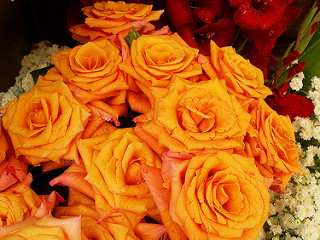

In [5]:
roses = list(data_path.glob(r'./roses/*.jpg'))
print(f'{len(roses)} rose images in {data_path}\\roses')
PIL.Image.open(str(roses[19]))

In [6]:
# ImageNet 데이터셋으로 학습한 모델을 불러온다.
# Image 의 사이즈는 (224, 224, 3)이고, 특성 병목 특성 추출을 위해 분류에 사용되는 마지막 부분의 flatten, dense layer는 포함하지 않는다.img_shape = img_size + (3,)
img_size = (224, 224)
img_shape = img_size + (3,)
vgg_model = tf.keras.applications.VGG16(
    include_top=True,
    input_shape=img_shape)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
vgg_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=img_shape)
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [8]:
batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="training",
    seed=seed,
    batch_size=batch_size,
    image_size=img_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split=0.2,
    subset="validation",
    seed=seed,
    batch_size=batch_size,
    image_size=img_size)

class_names = train_ds.class_names
print(f'\nThere are {len(class_names)} classes in dataset')
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.

There are 5 classes in dataset
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


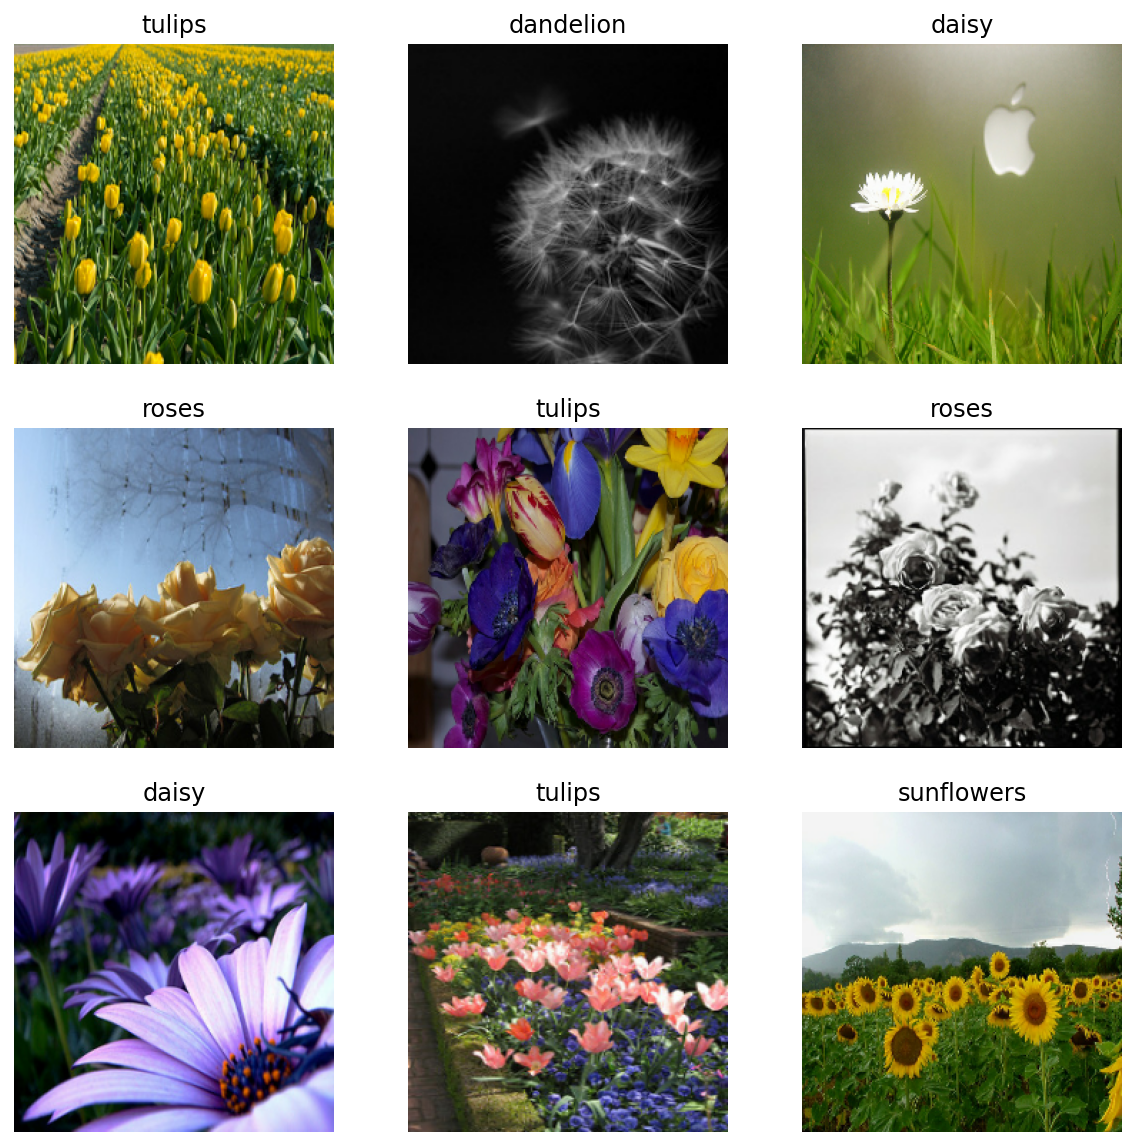

In [9]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
plt.show()

In [10]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 5)
val_ds = val_ds.skip(val_batches // 5)

print(f'val_batches: {val_batches}')
print(f'Number of test batches: {tf.data.experimental.cardinality(test_ds)}')
print(f'Number of validation batches: {tf.data.experimental.cardinality(val_ds)}')

val_batches: 23
Number of test batches: 4
Number of validation batches: 19


In [11]:
# 병목 특성 추출 (Bottleneck feature extraction)

In [12]:
# ImageNet 데이터셋으로 학습한 모델을 불러온다.
# Image 의 사이즈는 (224, 224, 3)이고, 특성 병목 특성 추출을 위해 분류에 사용되는 마지막 부분의 flatten, dense layer는 포함하지 않는다.img_shape = img_size + (3,)
img_shape = img_size + (3,)
base_model = tf.keras.applications.VGG16(
    include_top=False,
    input_shape=img_shape)

In [13]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


In [15]:
flatten_layer = tf.keras.layers.Flatten()
feature_flatten = flatten_layer(feature_batch)
print(f'flatten layer output shape : {feature_flatten.shape}')

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
global_averaged_batch = global_average_layer(feature_batch)
print(f'global average polling output shape : {global_averaged_batch.shape}') 

fc_layer = tf.keras.layers.Dense(256, activation="relu")
feature_batch_fc = fc_layer(global_averaged_batch)
print(f'dense layer output shape : {feature_batch_fc.shape}')

dropout_layer = tf.keras.layers.Dropout(0.25)
dropout_batach = dropout_layer(feature_batch_fc)
print(f'dropout layer output shape : {dropout_batach.shape}')

prediction_layer = tf.keras.layers.Dense(len(class_names), activation=None)
prediction_batch = prediction_layer(dropout_batach)
print(f'prediction layer output shape: {prediction_batch.shape}')

flatten layer output shape : (32, 25088)
global average polling output shape : (32, 512)
dense layer output shape : (32, 256)
dropout layer output shape : (32, 256)
prediction layer output shape: (32, 5)


In [16]:
inputs = tf.keras.Input(shape=(img_shape))
x = base_model(inputs, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
x = fc_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
print(f'trainable variable : {len(model.trainable_variables)}')
base_model.trainable = False
print(f'trainable variable : {len(model.trainable_variables)}')

trainable variable : 30
trainable variable : 4


In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 dense_1 (Dense)             (None, 5)                 1285      
                                                             

In [19]:
base_learning_rate = 0.0001
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [20]:
epochs = 10
val_loss0, val_accuracy0 = model.evaluate(val_ds)
train_loss0, train_accuracy0 = model.evaluate(train_ds)


92/92 [==============================] - 8s 91ms/step - loss: 6.1942 - accuracy: 0.2595


In [21]:
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds)

model.save('vgg16_flower_model')

Epoch 1/10
92/92 [==============================] - 10s 102ms/step - loss: 3.1953 - accuracy: 0.4166 - val_loss: 1.2942 - val_accuracy: 0.6535
Epoch 2/10
92/92 [==============================] - 9s 102ms/step - loss: 1.5879 - accuracy: 0.6345 - val_loss: 0.9679 - val_accuracy: 0.7195
Epoch 3/10
92/92 [==============================] - 9s 102ms/step - loss: 1.2019 - accuracy: 0.6969 - val_loss: 0.8414 - val_accuracy: 0.7624
Epoch 4/10
92/92 [==============================] - 9s 102ms/step - loss: 0.9695 - accuracy: 0.7381 - val_loss: 0.7990 - val_accuracy: 0.7888
Epoch 5/10
92/92 [==============================] - 9s 102ms/step - loss: 0.8629 - accuracy: 0.7595 - val_loss: 0.6684 - val_accuracy: 0.8152
Epoch 6/10
92/92 [==============================] - 9s 102ms/step - loss: 0.7669 - accuracy: 0.7783 - val_loss: 0.6941 - val_accuracy: 0.8020
Epoch 7/10
92/92 [==============================] - 9s 102ms/step - loss: 0.7056 - accuracy: 0.7858 - val_loss: 0.6772 - val_accuracy: 0.8036
Epoch

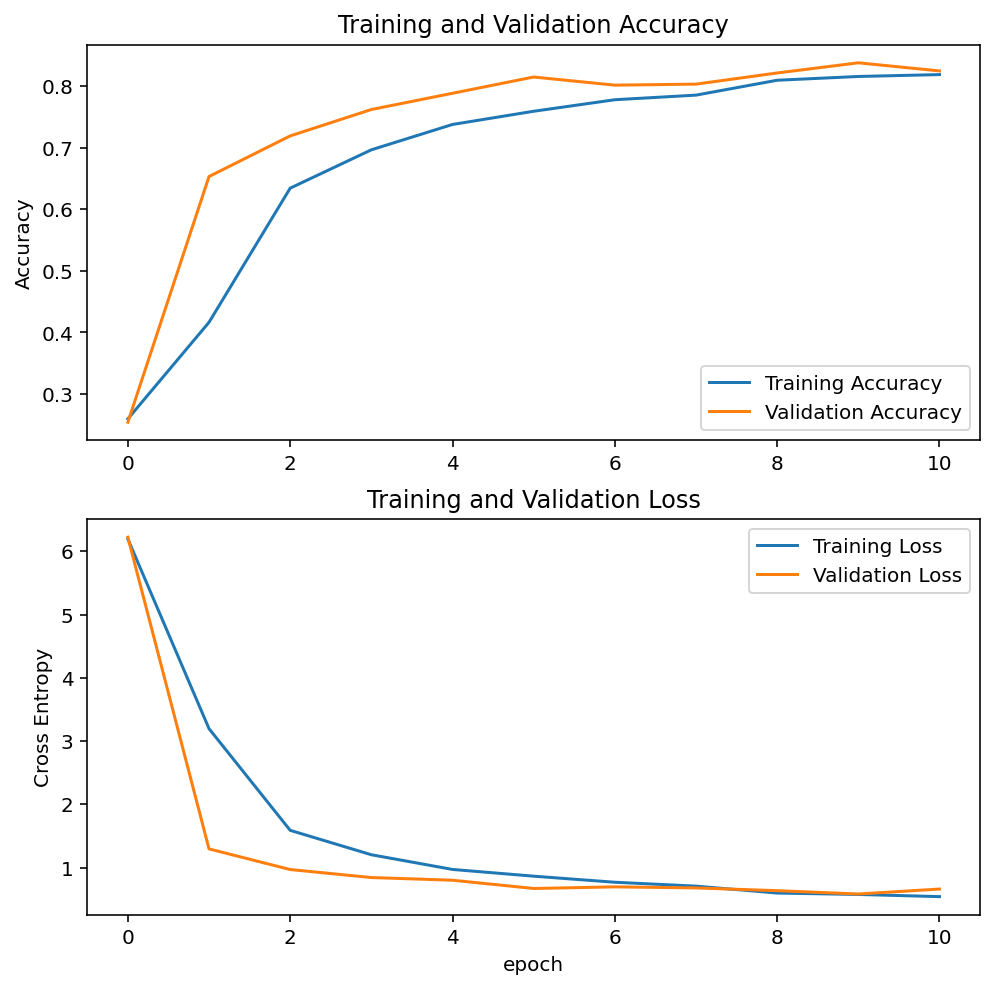

In [22]:
acc = [train_accuracy0] + history.history['accuracy']
val_acc = [val_accuracy0] + history.history['val_accuracy']

loss = [train_loss0] + history.history['loss']
val_loss = [val_loss0] + history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
loss_test, accuracy_test = model.evaluate(test_ds)
print('Test accuracy :', accuracy_test)

4/4 [==============================] - 0s 84ms/step - loss: 0.8113 - accuracy: 0.7969
Test accuracy : 0.796875


In [24]:
test_ds_list = list(test_ds.as_numpy_iterator())

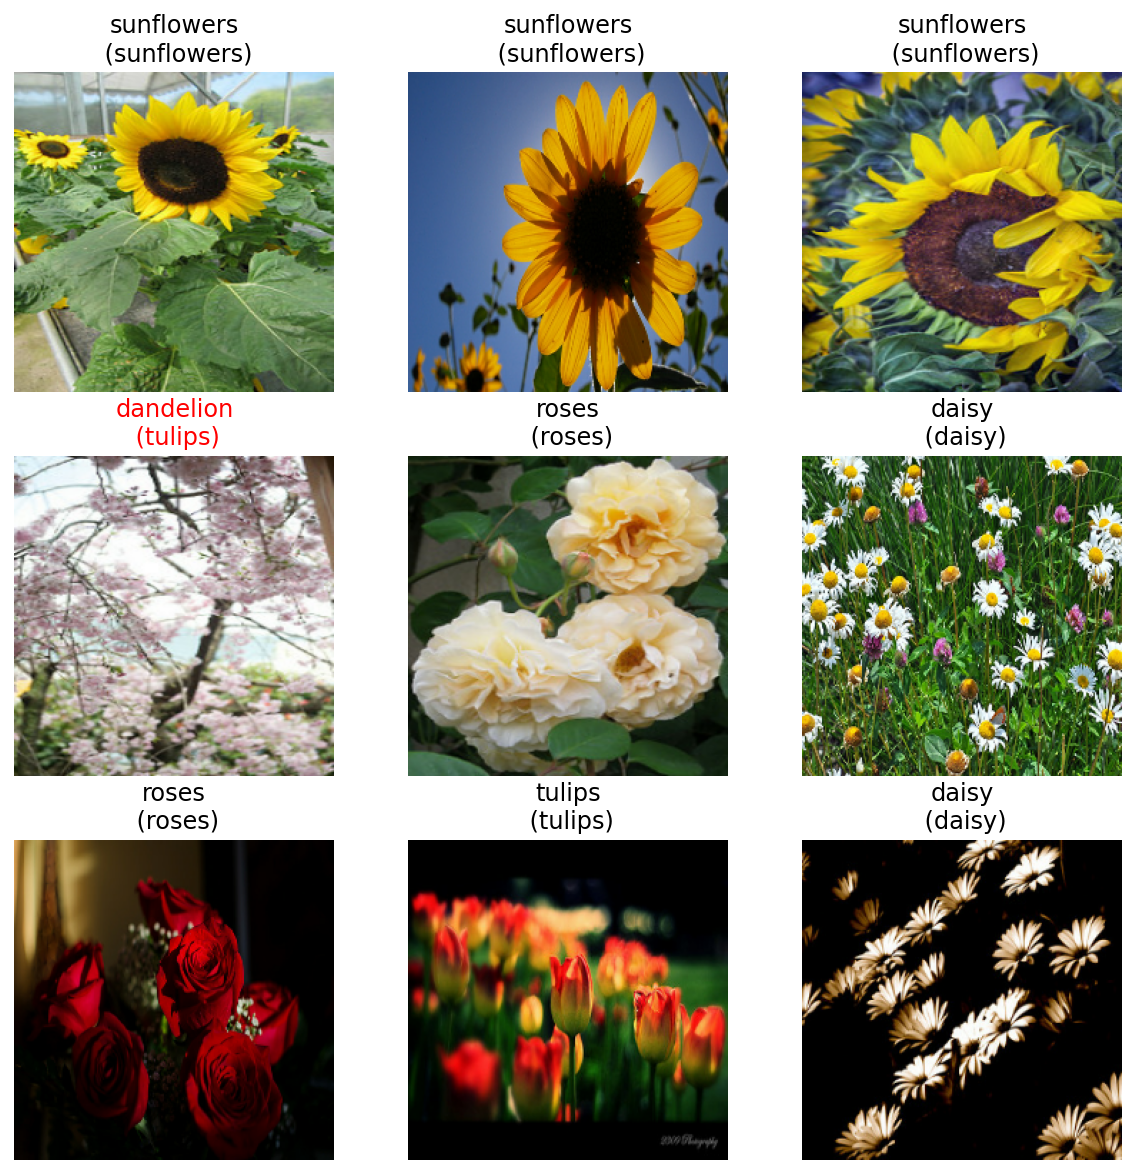

In [36]:
model = tf.keras.models.load_model('vgg16_flower_model')

#테스트 셋에서 한 개의 배치 (32장의 영상)을 예측 해본다.
image_batch, label_batch = test_ds_list[1]
predictions = model.predict_on_batch(image_batch)

# 확율로 표현하기 위해 softmax를 해준다.
predictions_softmax = tf.nn.softmax(predictions)
predictions_argmax = tf.argmax(predictions_softmax, axis=1).numpy()
result = predictions_argmax == label_batch

# 영상 위에 예측한 결과와 실제 라벨값을 괄호로 표현한다. 틀렸을 경우 빨간색으로 표시한다.
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f'{class_names[predictions_argmax[i]]}\n ({class_names[label_batch[i]]})', color='black' if result[i] else 'red')
    plt.axis("off")

In [26]:
model.trainable = True
print(f'trainable variable before Fine-tuning : {len(model.trainable_variables)}')

# base model의 레이어의 수를 확인.
print("Number of layers in the base model: ", len(base_model.layers))

# fine_tune_at 이전의 레이어들을 학습이 되지 않도록 한다.
fine_tune_at = 15
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

print(f'trainable variable for Fine-tuning : {len(model.trainable_variables)}')

model.summary()

trainable variable before Fine-tuning : 30
Number of layers in the base model:  19
trainable variable for Fine-tuning : 10
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 den

In [27]:
#learning_rate는 기존의 했던 것보다 작게 한다. 이경우엔 1/10로 설정하였다.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate/10),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

In [28]:
fine_tune_epochs = 10
total_epochs =  epochs + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds)

model.save('vgg16_flower_fine_tune_model')

Epoch 10/20
92/92 [==============================] - 11s 115ms/step - loss: 0.4932 - accuracy: 0.8273 - val_loss: 0.5099 - val_accuracy: 0.8383
Epoch 11/20
92/92 [==============================] - 11s 114ms/step - loss: 0.3090 - accuracy: 0.8913 - val_loss: 0.4713 - val_accuracy: 0.8465
Epoch 12/20
92/92 [==============================] - 11s 114ms/step - loss: 0.2313 - accuracy: 0.9189 - val_loss: 0.4261 - val_accuracy: 0.8729
Epoch 13/20
92/92 [==============================] - 11s 115ms/step - loss: 0.1888 - accuracy: 0.9356 - val_loss: 0.4028 - val_accuracy: 0.8713
Epoch 14/20
92/92 [==============================] - 11s 115ms/step - loss: 0.1512 - accuracy: 0.9445 - val_loss: 0.4538 - val_accuracy: 0.8647
Epoch 15/20
92/92 [==============================] - 11s 116ms/step - loss: 0.1253 - accuracy: 0.9561 - val_loss: 0.3777 - val_accuracy: 0.8828
Epoch 16/20
92/92 [==============================] - 11s 115ms/step - loss: 0.0925 - accuracy: 0.9683 - val_loss: 0.4333 - val_accuracy:

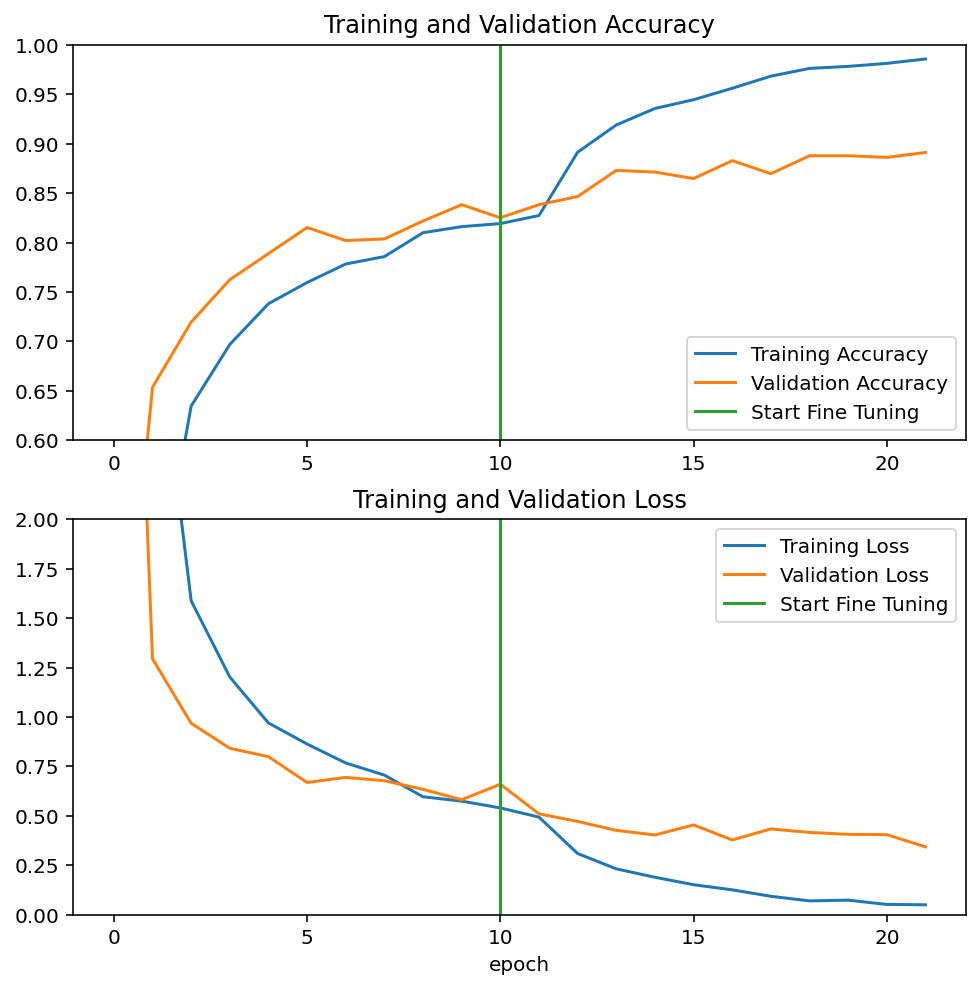

In [29]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.6, 1])
plt.plot([epochs,epochs],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([epochs,epochs],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss_test, accuracy_test = model.evaluate(test_ds)
print('Test accuracy :', accuracy_test)

4/4 [==============================] - 0s 90ms/step - loss: 0.2708 - accuracy: 0.8906
Test accuracy : 0.890625


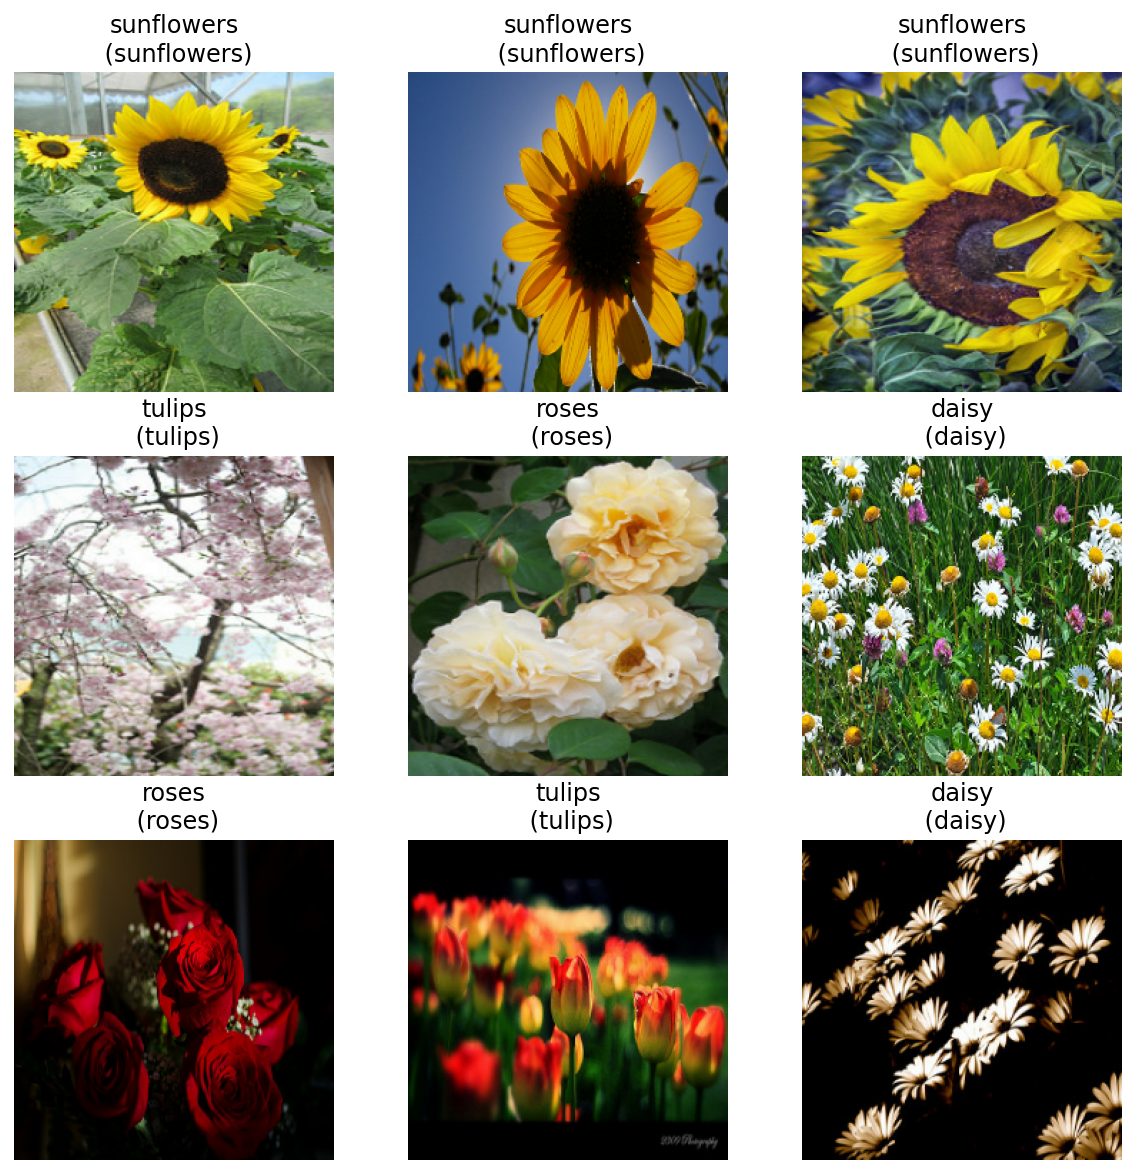

In [37]:
model = tf.keras.models.load_model('vgg16_flower_fine_tune_model')

#테스트 셋에서 한 개의 배치 (32장의 영상)을 예측 해본다.
predictions = model.predict_on_batch(image_batch)

# 확율로 표현하기 위해 softmax를 해준다.
predictions_softmax = tf.nn.softmax(predictions)
predictions_argmax = tf.argmax(predictions_softmax, axis=1).numpy()
result = predictions_argmax == label_batch

# 영상 위에 예측한 결과와 실제 라벨값을 괄호로 표현한다. 틀렸을 경우 빨간색으로 표시한다.
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(f'{class_names[predictions_argmax[i]]}\n ({class_names[label_batch[i]]})', color='black' if result[i] else 'red')
    plt.axis("off")